In [1]:
import os
import json
import matplotlib.pyplot as plt
import re
import seaborn as sns
import itertools
import math
import numpy as np

In [2]:
def load_checkpoints_in_order(task_dir):
    checkpoints = []
    checkpoint_files = []

    for filename in os.listdir(task_dir):
        checkpoint_path = os.path.join(task_dir, filename)
        
        if os.path.isdir(checkpoint_path) and filename.startswith('checkpoint-'):
            try:
                checkpoint_id = int(filename.replace('checkpoint-', ''))
                graph_path = os.path.join(checkpoint_path, 'graph.json')
                if os.path.isfile(graph_path):
                    checkpoint_files.append((checkpoint_id, graph_path))
            except ValueError:
                continue 

    checkpoint_files.sort(key=lambda x: x[0])

    for _, json_path in checkpoint_files:
        with open(json_path, 'r') as f:
            data = json.load(f)
            checkpoints.append(data)

    return checkpoints

In [3]:
def count_nodes_per_checkpoint(checkpoints):
    node_counts = []
    for checkpoint in checkpoints:
        nodes = checkpoint['nodes']
        true_count = sum(1 for node, state in nodes.items() if state)
        node_counts.append(true_count)
    return node_counts

def calculate_node_changes(checkpoints):
    changes = []
    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']
        added = sum(
            1 for node in curr_nodes
            if curr_nodes[node].get('in_graph', False) and not prev_nodes.get(node, {}).get('in_graph', False)
        )       

        removed = sum(
            1 for node in prev_nodes
            if prev_nodes[node].get('in_graph', False) and not curr_nodes.get(node, {}).get('in_graph', False)
        )
        changes.append(added + removed)

    return changes

def calculate_in_graph_changes_per_checkpoint(checkpoints):
    in_graph_changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']
        change_count = 0

        for edge in curr_edges.keys():
            prev_in_graph = prev_edges.get(edge, {}).get('in_graph', False)
            curr_in_graph = curr_edges[edge]['in_graph']
            if prev_in_graph != curr_in_graph: 
                change_count += 1

        in_graph_changes.append(change_count)

    return in_graph_changes

def calculate_edge_changes_top_95_percent(checkpoints):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1].get('edges', {})
        curr_edges = checkpoints[i].get('edges', {})

        prev_scores = [abs(v['score']) for v in prev_edges.values() if v]
        curr_scores = [abs(v['score']) for v in curr_edges.values() if v]

        prev_threshold = np.percentile(prev_scores, 95) if prev_scores else 0
        curr_threshold = np.percentile(curr_scores, 95) if curr_scores else 0

        prev_high_edges = set(e for e, v in prev_edges.items() if v and abs(v['score']) >= prev_threshold)
        curr_high_edges = set(e for e, v in curr_edges.items() if v and abs(v['score']) >= curr_threshold)

        changed_edges = prev_high_edges.symmetric_difference(curr_high_edges)
        print(f"Step {i} -- Prev threshold: {prev_threshold}, Curr threshold: {curr_threshold}, Changes: {len(changed_edges)}")
        changes.append(len(changed_edges))

    return changes

def calculate_delta_S(total_dir):
    checkpoints = load_checkpoints_in_order(total_dir)
    changes = calculate_in_graph_changes_per_checkpoint(checkpoints)

    initial_edges = checkpoints[0].get('edges', {})
    S0 = len(initial_edges)
    if S0 == 0:
        return 0

    n = len(changes)
    sum_relative_changes = sum(change / S0 for change in changes)

    delta_S = (sum_relative_changes / n) * 100  # percentage
    return delta_S


def visualize_fine_tunings(total_dirs: list, type = 'edges'):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 5))
    labels = []

    for total_dir in total_dirs:
        checkpoints = load_checkpoints_in_order(total_dir)
        if type == 'nodes': 
            changes = calculate_node_changes(checkpoints)
        else:
            changes = calculate_in_graph_changes_per_checkpoint(checkpoints)

        transitions = range(1, len(changes) + 1)
        label = os.path.basename(os.path.dirname(total_dir.rstrip('/')))
        labels.append(label)

        plt.plot(transitions, changes, marker='o', linestyle='-', label=label)

    plt.xlabel('Checkpoint Transition', fontsize=14)
    plt.ylabel(f'Number of {type} Changes', fontsize=14)
    plt.title(f'{type} changes Between Checkpoints Across Runs', fontsize=16)
    plt.legend(title="Runs", fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return labels

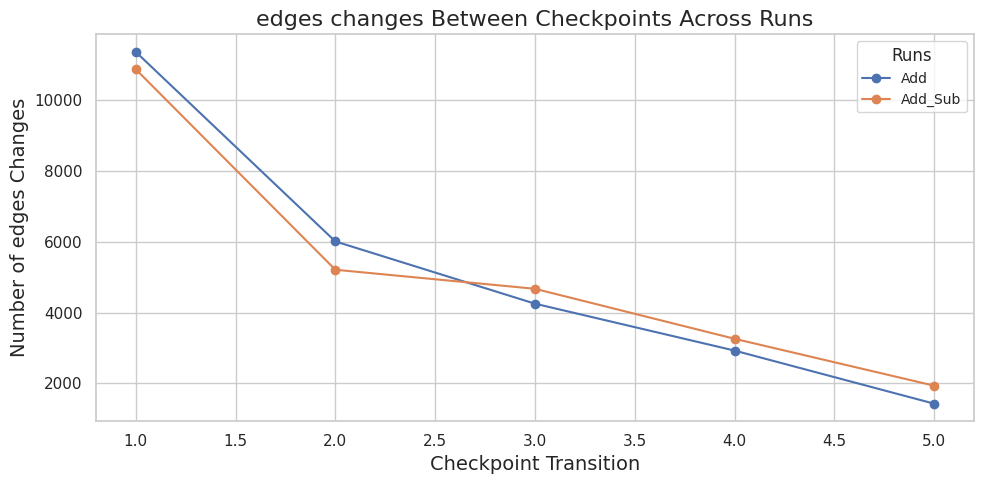

['Add', 'Add_Sub']

In [7]:
paths = ['results/Add/task_single' ,'results/Add_Sub/task_a']
visualize_fine_tunings(paths, type = 'edges')

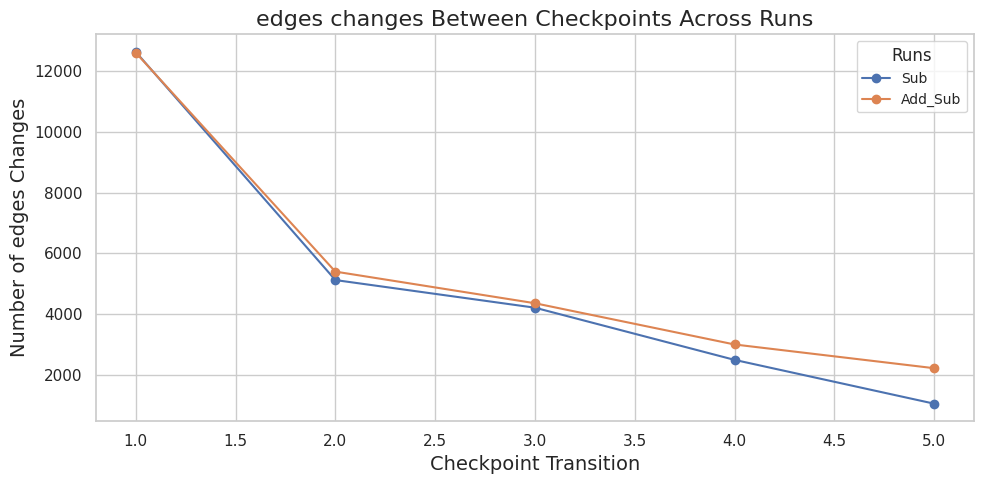

['Sub', 'Add_Sub']

In [8]:
paths = ['results/Sub/task_single' ,'results/Add_Sub/task_b']
visualize_fine_tunings(paths, type = 'edges')

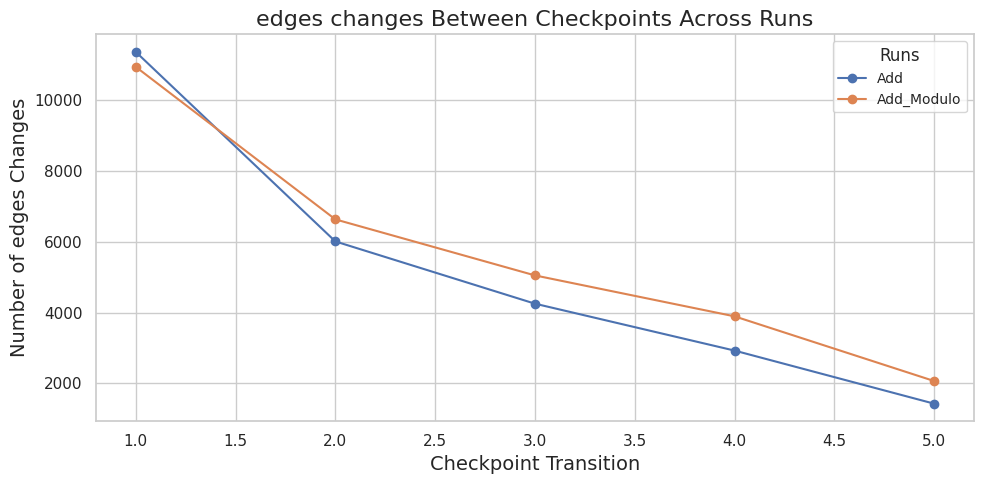

['Add', 'Add_Modulo']

In [9]:
paths = ['results/Add/task_single','results/Add_Modulo/task_a']
visualize_fine_tunings(paths, type = 'edges')

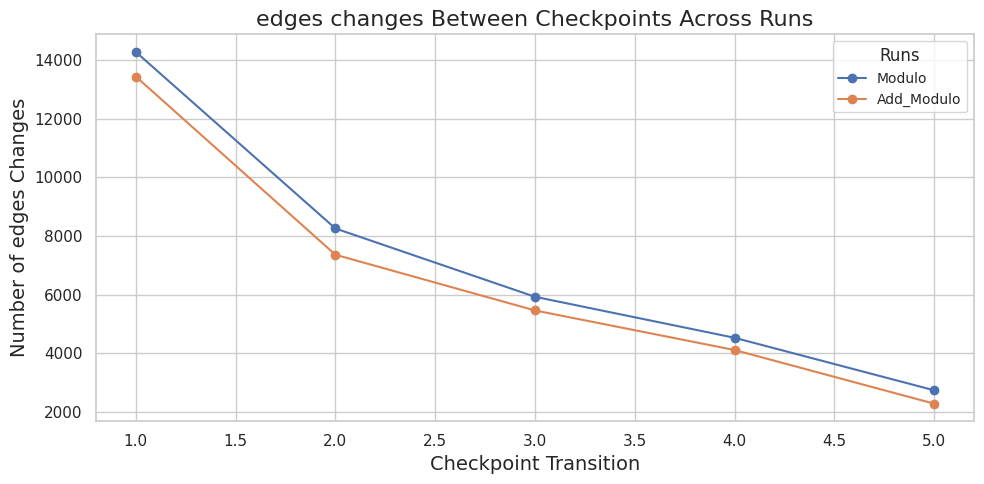

['Modulo', 'Add_Modulo']

In [10]:
paths = ['results/Modulo/task_single','results/Add_Modulo/task_b']
visualize_fine_tunings(paths, type = 'edges')